In [ ]:
import pandas as pd

df = pd.read_csv("data/tweetdfsiliconvb275t.csv", encoding="latin1", low_memory=False)

This code loads data from a CSV file into a DataFrame for analysis.

In [ ]:

import pandas as pd
import re
import spacy
import nltk
import contextlib
import os
import sys
from nltk.corpus import stopwords


# Load rows
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"] > "2023-03-09"].head(10000)
df = df.dropna(subset=["date"])

#Suppress nltk output 
with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        nltk.download("stopwords", quiet=True)

# Text preprocessing setup
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    text = re.sub(r"http\S+", "http", str(text))
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"[^A-Za-z\s]", "", text.lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_space]
    return " ".join(tokens)

df["clean_text"] = df["tweet"].astype(str).apply(preprocess)


This code imports necessary libraries, loads and cleans the first 20,000 rows of my data, sets up text preprocessing by removing stopwords and lemmatising with spaCy, and then applies this cleaning to the "tweet" column, saving the results in a new "clean_text" column.

In [23]:
from transformers import pipeline, logging

logging.set_verbosity_error()

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0
)

emotion_model = pipeline(
    "text-classification",
    
    model="cardiffnlp/twitter-roberta-base-emotion",
    top_k=None,
    device=0
)


df["sentiment"] = df["clean_text"].apply(
    lambda x: label_map[sentiment_model(x)[0]["label"]]
)

df["emotion"] = df["clean_text"].apply(
    lambda x: max(emotion_model(x)[0], key=lambda e: e["score"])["label"]
)


This code sets up two Hugging Face transformer pipelines for sentiment and emotion analysis, applies them to the cleaned tweet text, and adds the resulting sentiment and emotion labels as new columns in the DataFrame.

In [20]:
keywords = [
    "withdraw", "bank", "collapse", "fdic", "run", "money", "risk", "panic",
    "queue", "safe", "account", "deposit", "guarantee", "insured",
    # Additional SVB-relevant keywords:
    "svb", "silicon", "valley", "bailout", "rescue", "startup",
    "venture", "liquidity", "banking", "defaults", "crash"
]


def keyword_flags(text):
    words = set(text.split())
    return {kw: int(kw in words) for kw in keywords}

kw_df = df["clean_text"].apply(keyword_flags).apply(pd.Series)
df = pd.concat([df, kw_df], axis=1)

This code defines a list of relevant keywords, creates a function to flag their presence in each cleaned tweet, and then adds a new column for each keyword to the DataFrame indicating whether it appears in the tweet.

In [21]:
import pandas as pd

# Ensure 'date' is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Fix deprecation warning
df["hour"] = df["date"].dt.floor("h")

# Tweet volume per hour
tweet_volume = df["hour"].value_counts().sort_index()

# Sentiment per hour
sentiment_by_hour = (
    df.groupby("hour")["sentiment"]
    .value_counts()
    .unstack()
    .fillna(0)
    .sort_index()
)
# Emotion per hour
emotion_by_hour = (
    df.groupby("hour")["emotion"]
    .value_counts()
    .unstack()
    .fillna(0)
    .sort_index()
)

# Keywords per hour 
if 'keywords' in globals():
    keyword_trends = df.groupby("hour")[keywords].sum()


This code converts the "date" column to datetime, extracts the hour for each tweet, then calculates tweet counts, sentiment, emotion, and keyword trends by hour for analysis.

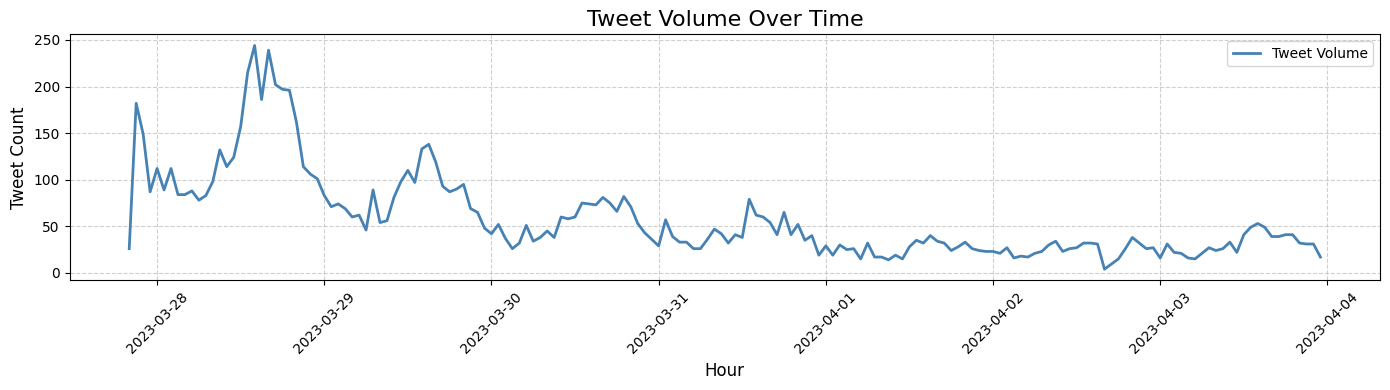

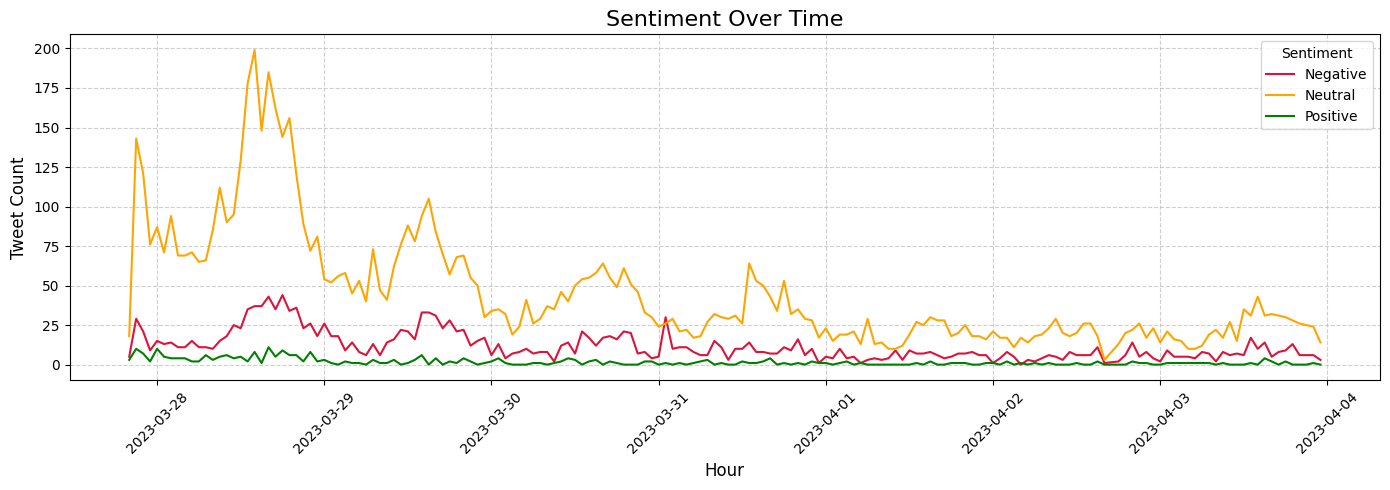

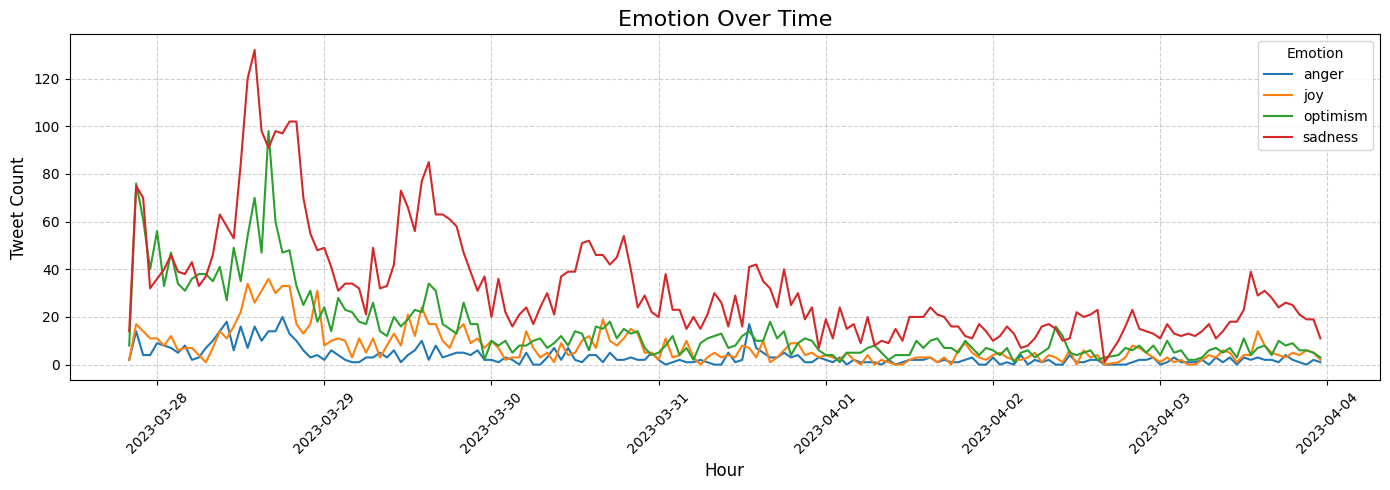

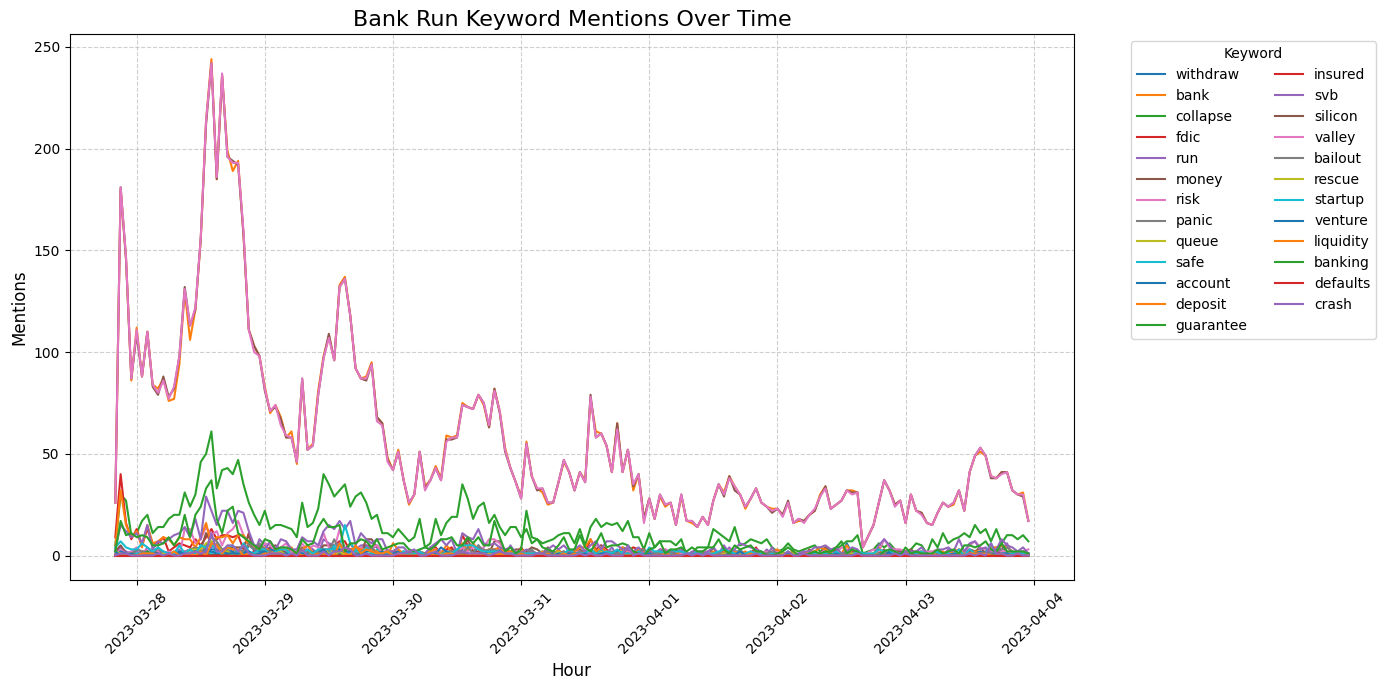

In [22]:
import matplotlib.pyplot as plt

#Tweet Volume Over Time 
plt.figure(figsize=(14, 4))
plt.plot(tweet_volume.index, tweet_volume.values, color="steelblue", linewidth=2, label="Tweet Volume")
plt.title("Tweet Volume Over Time", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

#Sentiment Over Time 
plt.figure(figsize=(14, 5))
colors = {'Negative': 'crimson', 'Neutral': 'orange', 'Positive': 'green'}
for sentiment in sentiment_by_hour.columns:
    plt.plot(sentiment_by_hour.index, sentiment_by_hour[sentiment],
             label=sentiment, color=colors.get(sentiment, 'gray'))

plt.title("Sentiment Over Time", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#Emotion Over Time
plt.figure(figsize=(14, 5))
for emotion in emotion_by_hour.columns:
    plt.plot(emotion_by_hour.index, emotion_by_hour[emotion], label=emotion)

plt.title("Emotion Over Time", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

#Bank Run Keyword Mentions Over Time
plt.figure(figsize=(14, 7))
for col in keyword_trends.columns:
    plt.plot(keyword_trends.index, keyword_trends[col], label=col)

plt.title("Bank Run Keyword Mentions Over Time", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Mentions", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()